In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

from utils.fmri_encoding import normalize_data, create_windowed_data, mod, compute_voxel_correlations
from scipy.io import loadmat
import numpy as np
import numpy as np
from scipy.io import loadmat

#load audiovisual features (CAV-MAE)
cavmae_data = loadmat("../data/cavmae_av_embeddings.mat")
X_av = cavmae_data["audiovisual_embeddings"]
print("CAV-MAE features shape:", X_av.shape)


CAV-MAE features shape: (3655, 768)


In [2]:
beats_data = loadmat("../data/features_per_sec.mat")
X_audio = beats_data["features_per_sec"]
clip_data = loadmat("../data/vision_clip_features.mat")
X_visual = clip_data["features"]
print("BEATs audio features shape:", X_audio.shape)
print("CLIP visual features shape:", X_visual.shape)


BEATs audio features shape: (3655, 768)
CLIP visual features shape: (3655, 768)


In [3]:
# concat audio and visual features
X_av_concat = np.concatenate([X_audio, X_visual], axis=1)
print("Combined BEATs+CLIP features shape:", X_av_concat.shape)

#load fMRI data for left and right hemispheres
lh_data = loadmat("../notmean_left_Meanfile.mat")
rh_data = loadmat("../notmean_right_Meanfile.mat")
Y_left = lh_data["Left_data"]
Y_right = rh_data["Right_data"]
#combine full brain (voxels* time_points)
Y_full = np.concatenate([Y_left, Y_right], axis=0).T
print("Brain data (full cortex) shape:", Y_full.shape)


Combined BEATs+CLIP features shape: (3655, 1536)
Brain data (full cortex) shape: (3655, 64984)


In [4]:
X_av = normalize_data(X_av)  #z-score features
X_av_concat = normalize_data(X_av_concat)
Y_full = normalize_data(Y_full)  #z-score fmri signals


In [5]:
window_length = 10
X_win_av, Y_win = create_windowed_data(X_av, Y_full, window_length)
X_win_av2, Y_win2 = create_windowed_data(X_av_concat, Y_full, window_length)


In [6]:

print("Windowed feature shape (Model1):", X_win_av.shape)
print("Windowed feature shape (Model2):", X_win_av2.shape)
print("Windowed target (brain) shape:", Y_win.shape)

Windowed feature shape (Model1): (3646, 7680)
Windowed feature shape (Model2): (3646, 15360)
Windowed target (brain) shape: (3646, 64984)


In [7]:
from sklearn.linear_model import Ridge

#split into train/test (80/20 split without shuffling)
n_samples = X_win_av.shape[0]
split_idx = int(0.8 * n_samples)
X_train1, X_test1 = X_win_av[:split_idx], X_win_av[split_idx:]
Y_train, Y_test = Y_win[:split_idx], Y_win[split_idx:]
X_train2, X_test2 = X_win_av2[:split_idx], X_win_av2[split_idx:]

print("Train set size:", X_train1.shape[0], "samples")
print("Test set size:", X_test1.shape[0], "samples")

Train set size: 2916 samples
Test set size: 730 samples


In [8]:
from sklearn.linear_model import LinearRegression, Ridge

print("Model 1: CAV-MAE Features")

#linear Regression
linear1 = LinearRegression()
linear1.fit(X_train1, Y_train)
Y_pred1_linear = linear1.predict(X_test1)
print("Linear Regression (Model 1) prediction shape:", Y_pred1_linear.shape)

#rr
ridge1 = Ridge(alpha=1.0)
ridge1.fit(X_train1, Y_train)
Y_pred1_ridge = ridge1.predict(X_test1)
print("Ridge Regression (Model 1) prediction shape:", Y_pred1_ridge.shape)

Model 1: CAV-MAE Features
Linear Regression (Model 1) prediction shape: (730, 64984)


/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=2.42085e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Ridge Regression (Model 1) prediction shape: (730, 64984)


In [9]:
print("Model 2: BEATs + CLIP Features")

#linear Regression
linear2 = LinearRegression()
linear2.fit(X_train2, Y_train)
Y_pred2_linear = linear2.predict(X_test2)
print("Linear Regression (Model 2) prediction shape:", Y_pred2_linear.shape)

#ridge Regression
ridge2 = Ridge(alpha=1.0)
ridge2.fit(X_train2, Y_train)
Y_pred2_ridge = ridge2.predict(X_test2)
print("Ridge Regression (Model 2) prediction shape:", Y_pred2_ridge.shape)

Model 2: BEATs + CLIP Features
Linear Regression (Model 2) prediction shape: (730, 64984)


/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=2.80597e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Ridge Regression (Model 2) prediction shape: (730, 64984)


In [10]:
from scipy.stats import pearsonr
import scipy.io as sio

r_values_cavmae = compute_voxel_correlations(Y_test, Y_pred1_linear)
r_values_beats_clip = compute_voxel_correlations(Y_test, Y_pred2_linear)

# # Save correlation values to MATLAB .mat files
# sio.savemat("ridge_cavmae_r_values.mat", {"r_values": r_values_cavmae})
# sio.savemat("ridge_beats_clip_r_values.mat", {"r_values": r_values_beats_clip})

valid_idx_cavmae = ~np.isnan(r_values_cavmae)
mean_r_cavmae = np.nanmean(r_values_cavmae)
print(f"Model 1 (CAV-MAE, Linear) mean r: {mean_r_cavmae:.3f}")
print(f"Model 1 valid voxels: {valid_idx_cavmae.sum()} / {len(r_values_cavmae)}")

valid_idx_beats_clip = ~np.isnan(r_values_beats_clip)
mean_r_beats_clip = np.nanmean(r_values_beats_clip)
print(f"Model 2 (BEATs+CLIP, Linear) mean r: {mean_r_beats_clip:.3f}")
print(f"Model 2 valid voxels: {valid_idx_beats_clip.sum()} / {len(r_values_beats_clip)}")


Model 1 (CAV-MAE, Linear) mean r: 0.278
Model 1 valid voxels: 59412 / 64984
Model 2 (BEATs+CLIP, Linear) mean r: 0.337
Model 2 valid voxels: 59412 / 64984


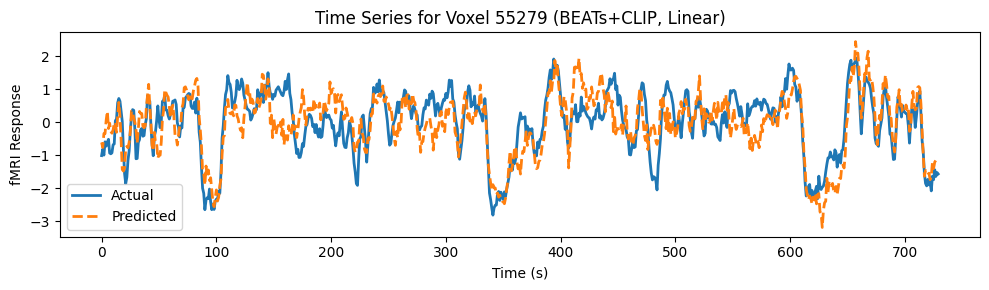

In [16]:
best_voxel = np.nanargmax(r_values_beats_clip)

plt.figure(figsize=(10, 3))
plt.plot(Y_test[:, best_voxel], label="Actual", linewidth=2)
plt.plot(Y_pred2_linear[:, best_voxel], label="Predicted", linestyle='--', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("fMRI Response")
plt.title(f"Time Series for Voxel {best_voxel} (BEATs+CLIP, Linear)")
plt.legend()
plt.tight_layout()
plt.show()


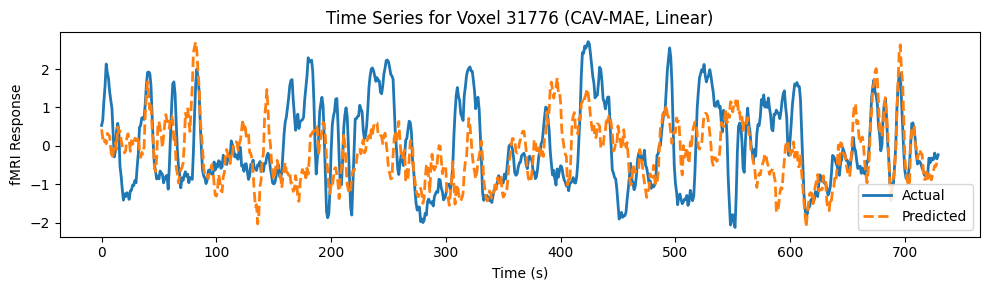

In [17]:
best_voxel = np.nanargmax(r_values_cavmae)

plt.figure(figsize=(10, 3))
plt.plot(Y_test[:, best_voxel], label="Actual", linewidth=2)
plt.plot(Y_pred2_linear[:, best_voxel], label="Predicted", linestyle='--', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("fMRI Response")
plt.title(f"Time Series for Voxel {best_voxel} (CAV-MAE, Linear)")
plt.legend()
plt.tight_layout()
plt.show()


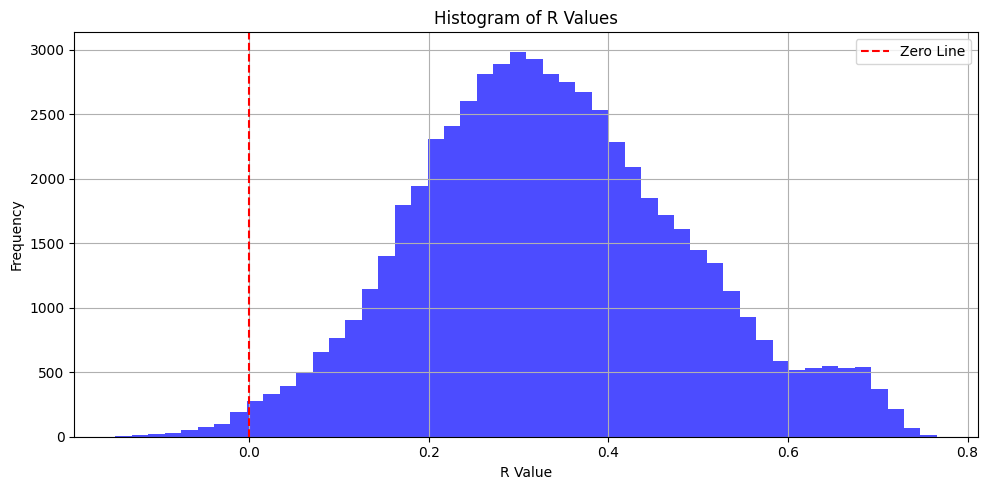

In [18]:
import numpy as np
import matplotlib.pyplot as plt

r_values = r_values_beats_clip

#remove nan
valid_r = r_values[~np.isnan(r_values)]

plt.figure(figsize=(10, 5))
plt.hist(valid_r, bins=50, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')
plt.title("Histogram of R Values")
plt.xlabel("R Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


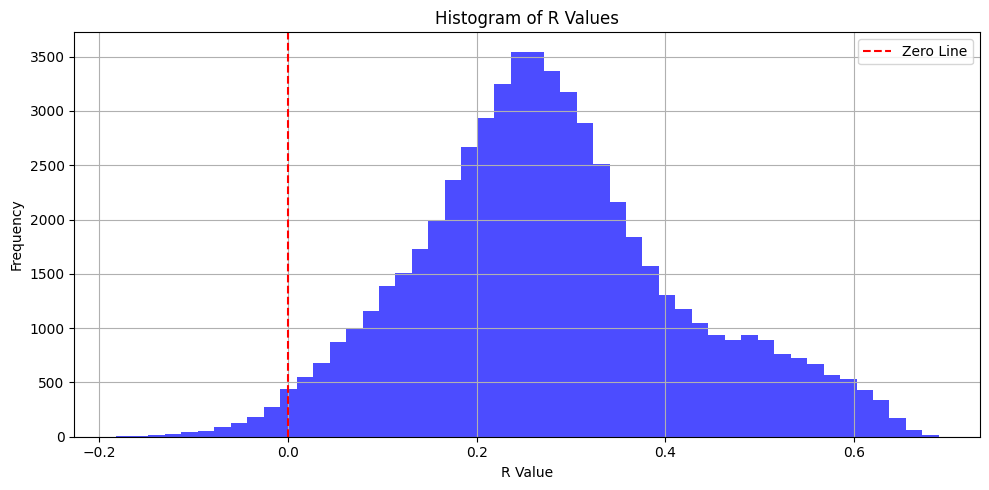

In [19]:
import numpy as np
import matplotlib.pyplot as plt

r_values = r_values_cavmae
valid_r = r_values[~np.isnan(r_values)]

plt.figure(figsize=(10, 5))
plt.hist(valid_r, bins=50, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')
plt.title("Histogram of R Values")
plt.xlabel("R Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

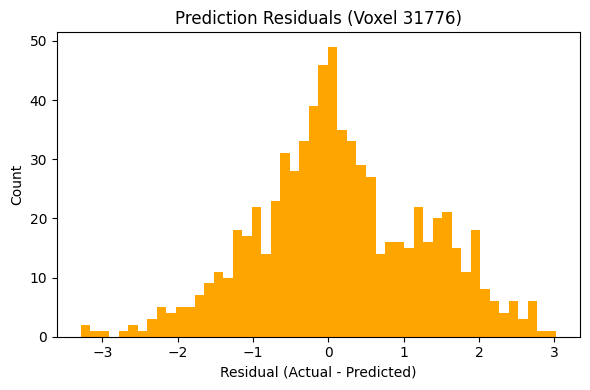

In [20]:
residuals = Y_test[:, best_voxel] - Y_pred2_linear[:, best_voxel]

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, color='orange')
plt.title(f"Prediction Residuals (Voxel {best_voxel})")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}")

cuda


In [23]:
#windowed feature-label pairs -> create fmri labels once
X_win_audio, Y_win = create_windowed_data(X_audio, Y_full, window_length)#get beats audio featuers (time steps, dimensions per time)
X_win_visual, _ = create_windowed_data(X_visual, Y_full, window_length) #get clip visual features
X_win_beats_clip, _ = create_windowed_data(X_av_concat, Y_full, window_length)#get beats+clip audio-visual features
X_win_cavmae, _ = create_windowed_data(X_av, Y_full, window_length)#get cav-mae audio-visual features

left_vox = Y_win[:, :32492] #1st 32k voxels left hemisphere -> Y_win (num windows, num voxels)
right_vox = Y_win[:, 32492:] #last 32k voxels right hemisphere
Y_win_subset = np.concatenate([left_vox[:, :5000], right_vox[:, :5000]], axis=1)#only do 10k voxel cuda run out of mem otherwise
rvalues_audio = mod(X_win_audio, Y_win_subset, "Audio only (BEATs)", batch_size=256)
torch.cuda.empty_cache()
import gc; gc.collect()
rvalues_visual = mod(X_win_visual, Y_win_subset, "Visual only (CLIP)", batch_size=256)
torch.cuda.empty_cache()
gc.collect()
#decrease batch sizes for multimodal models to prevent crash
rvalues_beats_clip = mod(X_win_beats_clip, Y_win_subset, "Multimodal (BEATs+CLIP)", batch_size=128)
torch.cuda.empty_cache()
gc.collect()
rvalues_cavmae = mod(X_win_cavmae, Y_win_subset, "Multimodal (CAV-MAE)", batch_size=128)
torch.cuda.empty_cache()
gc.collect()

mean_r_audio = np.nanmean(rvalues_audio)#ignore empty voxels
mean_r_visual = np.nanmean(rvalues_visual)
mean_r_beats_clip = np.nanmean(rvalues_beats_clip)
mean_r_cavmae = np.nanmean(rvalues_cavmae)
max_r_audio = np.nanmax(rvalues_audio)
max_r_visual = np.nanmax(rvalues_visual)
max_r_beats_clip = np.nanmax(rvalues_beats_clip)
max_r_cavmae = np.nanmax(rvalues_cavmae)

print(f"Audio only - BEATs:         Mean r = {mean_r_audio:}")
print(f"Visual only - CLIP:         Mean r = {mean_r_visual:}")
print(f"Multimodal - BEATs + CLIP:  Mean r = {mean_r_beats_clip:}")
print(f"Multimodal - CAV-MAE:       Mean r = {mean_r_cavmae:}")
print(f"Audio only - BEATs:         Max r = {max_r_audio:}")
print(f"Visual only - CLIP:         Max r = {max_r_visual:}")
print(f"Multimodal - BEATs + CLIP:  Max r = {max_r_beats_clip:}")
print(f"Multimodal - CAV-MAE:       Max r = {max_r_cavmae:}")


Audio only - BEATs:         Mean r = -0.02629408588537128
Visual only - CLIP:         Mean r = 0.37490369864088663
Multimodal - BEATs + CLIP:  Mean r = 0.3067540098283995
Multimodal - CAV-MAE:       Mean r = 0.3474561231384732
Audio only - BEATs:         Max r = 0.2931283909608914
Visual only - CLIP:         Max r = 0.748219770446179
Multimodal - BEATs + CLIP:  Max r = 0.6904078723181787
Multimodal - CAV-MAE:       Max r = 0.7621320064649283


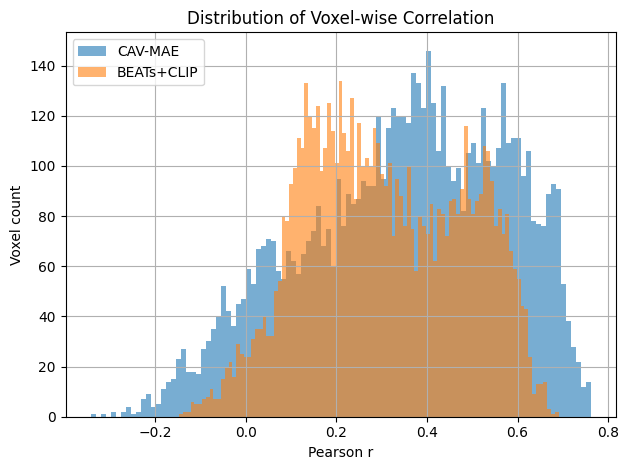

In [25]:
plt.figure()#with model fitting and RR
plt.hist(rvalues_cavmae[~np.isnan(rvalues_cavmae)], bins=100, alpha=0.6, label="CAV-MAE")
plt.hist(rvalues_beats_clip[~np.isnan(rvalues_beats_clip)], bins=100, alpha=0.6, label="BEATs+CLIP")
plt.xlabel("Pearson r")
plt.ylabel("Voxel count")
plt.title("Distribution of Voxel-wise Correlation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
